In [1]:
from scipy.io import wavfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import numpy as np
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dot, Activation, Concatenate , Dropout , Flatten , Permute , Layer , GlobalMaxPooling2D
from keras.layers import Bidirectional, TimeDistributed, Lambda
import keras.backend as K
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [2]:
csv_dir = "Labels based on .wav file names/"
dataset = []
for csv_file in os.listdir(csv_dir):
    csv_list = pd.read_csv(csv_dir+csv_file).to_numpy()
    wave_files = csv_list[:,0].tolist()
    labels = csv_list[:,1].tolist()
    labels = [0 if label == -1 else label for label in labels]

    for idx, wave_file in enumerate(wave_files):
        samplerate, data = wavfile.read(f'./wav signals/{wave_file}.wav')
        
        dataset.append([data,labels[idx]])



In [3]:
min_len = np.inf
max_len = 0
mean = 0
for data in dataset:
    mean+= data[0].shape[0]
    if data[0].shape[0] < min_len:
        min_len = data[0].shape[0]
    if data[0].shape[0] > max_len:
        max_len = data[0].shape[0]
print(min_len)

10611


In [4]:
for idx, data in enumerate(dataset):
    audio_data = data[0]
    min_val = int(np.min(audio_data))
    max_val = int(np.max(audio_data))
    scaled_data = ((audio_data - min_val) / (max_val - min_val)) * 2 - 1
    cut_data = scaled_data[:min_len]
    dataset[idx][0] = cut_data
    

In [5]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
len(train), len(test)


(784, 197)

In [6]:
x_train = np.array([i[0] for i in train])
x_test = np.array([i[0] for i in test])

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


In [7]:
y_train = np.array([i[1] for i in train])
y_test = np.array([i[1] for i in test])

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [8]:
print(x_train.shape)
print(y_train.shape)


(784, 10611, 1)
(784, 1)


In [9]:
input_shape = (min_len, 1)

In [10]:
class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)


In [11]:
input_layer = Input(shape=input_shape)
bi_lstm_layer = Bidirectional(LSTM(32 ,return_sequences=True))(input_layer)
att_layer = Attention(return_sequences=False)(bi_lstm_layer) 
outputs=Dense(1, activation='sigmoid')(att_layer)
model= Model(input_layer,outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10611, 1)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 10611, 64)        8704      
 l)                                                              
                                                                 
 attention (Attention)       (None, 64)                10675     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 19,444
Trainable params: 19,444
Non-trainable params: 0
_________________________________________________________________


In [13]:
total_samples = len(x_train)
batch_size = 32

steps_per_epoch = total_samples // batch_size
if total_samples % batch_size != 0:
    steps_per_epoch += 1

model.fit(x_train,y_train,
          batch_size = batch_size,                            
          epochs = 50,
          steps_per_epoch=steps_per_epoch ,                                
          validation_data=(x_test, y_test)
         )

Epoch 1/50
25/25 [==============================] - 136s 5s/step - loss: 0.6746 - accuracy: 0.5344 - val_loss: 0.6553 - val_accuracy: 0.6294
Epoch 2/50
25/25 [==============================] - 146s 6s/step - loss: 0.6456 - accuracy: 0.6569 - val_loss: 0.6470 - val_accuracy: 0.6802
Epoch 3/50
25/25 [==============================] - 155s 6s/step - loss: 0.6263 - accuracy: 0.6939 - val_loss: 0.6467 - val_accuracy: 0.6294
Epoch 4/50
25/25 [==============================] - 140s 6s/step - loss: 0.6190 - accuracy: 0.6939 - val_loss: 0.6425 - val_accuracy: 0.6345
Epoch 5/50
25/25 [==============================] - 135s 5s/step - loss: 0.6195 - accuracy: 0.6901 - val_loss: 0.6420 - val_accuracy: 0.6294
Epoch 6/50
25/25 [==============================] - 148s 6s/step - loss: 0.6080 - accuracy: 0.6952 - val_loss: 0.6454 - val_accuracy: 0.6447
Epoch 7/50
25/25 [==============================] - 199s 8s/step - loss: 0.6084 - accuracy: 0.7066 - val_loss: 0.6337 - val_accuracy: 0.6447
Epoch 8/50
25

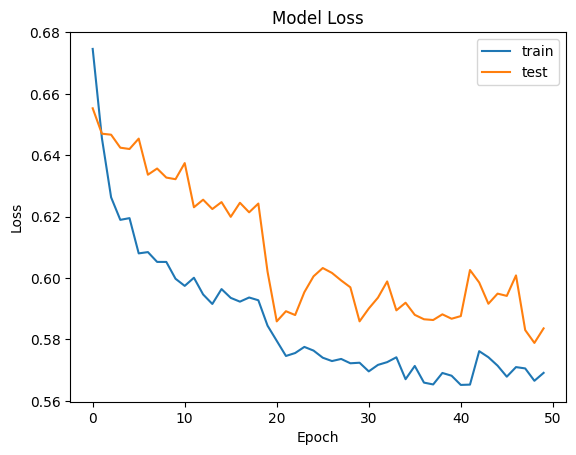

In [14]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()


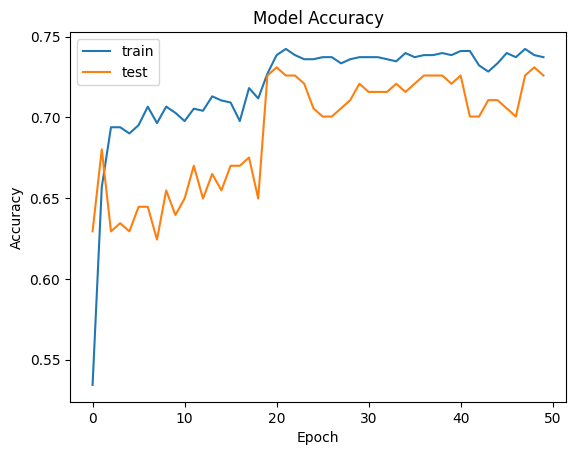

In [15]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()


In [16]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1-score: ", f1_score(y_test, y_pred))


7/7 [==============================] - 4s 519ms/step
Accuracy:  0.7258883248730964
Precision:  0.691358024691358
Recall:  0.6588235294117647
F1-score:  0.674698795180723
